In [11]:
import pandas as pd
from sqlalchemy import create_engine

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics'  

# Creating connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# File paths for all the datasets
csv_paths = {
    "orders": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_orders_dataset.csv",
    "customers": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_customers_dataset.csv",
    "order_items": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_order_items_dataset.csv",
    "order_reviews": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_order_reviews_dataset.csv",
    "order_payments": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_order_payments_dataset.csv",
    "products": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_products_dataset.csv",
    "sellers": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_sellers_dataset.csv",
    "geolocation": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\olist_geolocation_dataset.csv",
    "category_translation": r"C:\Users\USER\Documents\Projects\Customer Analytics\archive (1) (1)\product_category_name_translation.csv"
}

# Upload each CSV to MySQL
for table, path in csv_paths.items():
    print(f"Uploading: {table}")
    df = pd.read_csv(path)
    df.to_sql(table, engine, index=False, if_exists='replace')  # use 'append' if you don’t want to overwrite
    print(f"✅ Done: {table}")


Uploading: orders
✅ Done: orders
Uploading: customers
✅ Done: customers
Uploading: order_items
✅ Done: order_items
Uploading: order_reviews
✅ Done: order_reviews
Uploading: order_payments
✅ Done: order_payments
Uploading: products
✅ Done: products
Uploading: sellers
✅ Done: sellers
Uploading: geolocation
✅ Done: geolocation
Uploading: category_translation
✅ Done: category_translation


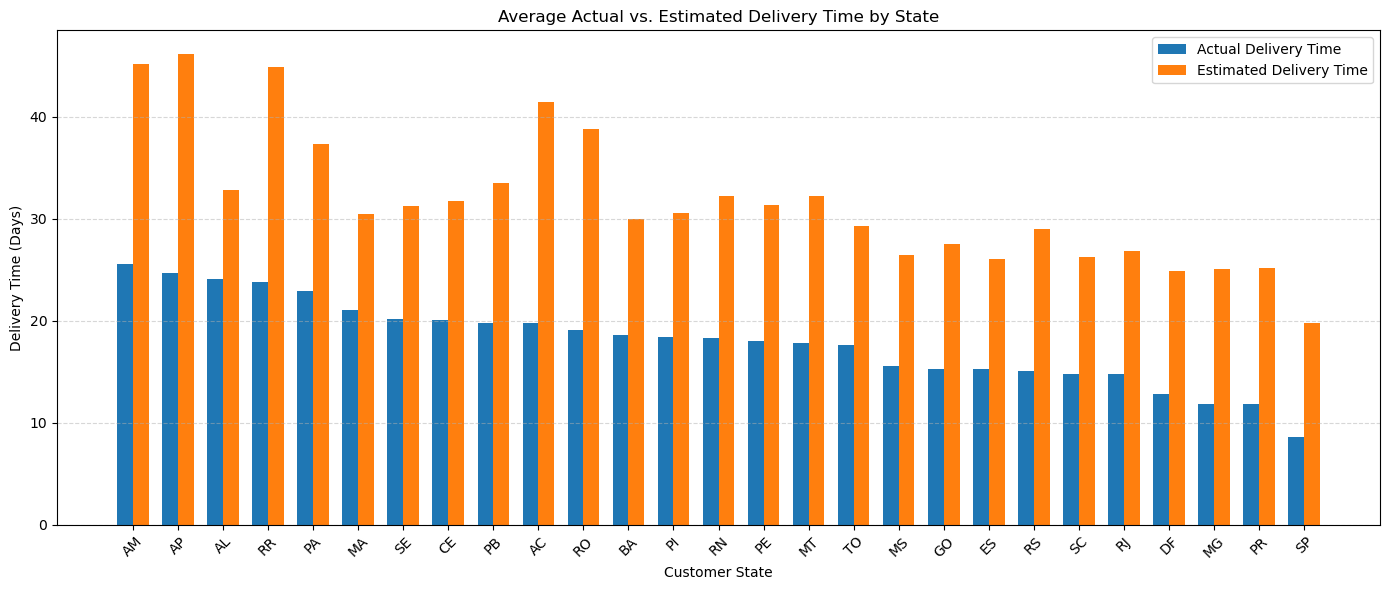

In [21]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics'  

# Create connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

query = """
SELECT 
    c.customer_state,
    ROUND(AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)), 2) AS avg_actual_delivery_time,
    ROUND(AVG(DATEDIFF(o.order_estimated_delivery_date, o.order_purchase_timestamp)), 2) AS avg_estimated_delivery_time
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_estimated_delivery_date IS NOT NULL
  AND DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) BETWEEN 0 AND 60
  AND DATEDIFF(o.order_estimated_delivery_date, o.order_purchase_timestamp) BETWEEN 0 AND 60
GROUP BY c.customer_state
ORDER BY avg_actual_delivery_time DESC;
"""

# STEP 3: Run query and load output into DataFrame
df = pd.read_sql(query, engine)

# Create x locations for each state
x = np.arange(len(df['customer_state']))
width = 0.35  # width of each bar

plt.figure(figsize=(14, 6))

# Plot actual and estimated side-by-side
plt.bar(x - width/2, df['avg_actual_delivery_time'], width, label='Actual Delivery Time')
plt.bar(x + width/2, df['avg_estimated_delivery_time'], width, label='Estimated Delivery Time')

# Labels and title
plt.xlabel("Customer State")
plt.ylabel("Delivery Time (Days)")
plt.title("Average Actual vs. Estimated Delivery Time by State")
plt.xticks(x, df['customer_state'], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### 📊 Insight: Average Actual vs. Estimated Delivery Time by State

This grouped bar chart visualizes the **average actual delivery time** versus **estimated delivery time** for orders across different customer states.

**Key Observations:**
- 🔶 In nearly all states, the **estimated delivery time** is **longer** than the actual delivery time. This suggests that the system tends to **overestimate delivery duration**, likely to ensure that deadlines are met and avoid customer dissatisfaction from late deliveries.
- 📍 States such as **AM, AP, and PA** show the **largest delivery overestimations**, potentially due to geographical remoteness or logistic challenges.
- 🏙️ **SP (São Paulo)** has the **shortest actual delivery time**, which aligns with its role as a central commercial and logistical hub in Brazil.

**Implications:**
- While overestimating delivery time protects against delays, large discrepancies could lead to **reduced trust** in the platform’s accuracy.
- States with high deviation may benefit from **logistics optimization** and **dynamic delivery time predictions** to enhance the user experience and operational efficiency.

This analysis supports potential improvements in **delivery estimate accuracy** and **customer satisfaction strategies** across regions.


import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
# Step 2: Query data

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics' 

# Creating connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

query = """
SELECT
    p.payment_type,
    CASE
        WHEN DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) <= 5 THEN 'fast'
        WHEN DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) BETWEEN 6 AND 10 THEN 'average'
        ELSE 'slow'
    END AS delivery_speed,
    ROUND(AVG(r.review_score), 2) AS avg_review_score
FROM orders o
JOIN order_reviews r ON o.order_id = r.order_id
JOIN order_payments p ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND r.review_score IS NOT NULL
GROUP BY 
    p.payment_type,
    CASE
        WHEN DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) <= 5 THEN 'fast'
        WHEN DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) BETWEEN 6 AND 10 THEN 'average'
        ELSE 'slow'
    END
ORDER BY 
    p.payment_type,
    delivery_speed;
"""

df = pd.read_sql(query, engine)


plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='payment_type', y='avg_review_score', hue='delivery_speed')

plt.title("Average Review Score by Payment Type and Delivery Speed")
plt.ylabel("Average Review Score")
plt.xlabel("Payment Type")
plt.ylim(0, 5)  # review scores range from 1 to 5
plt.legend(title="Delivery Speed")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### ⭐ Insight: Average Review Score by Payment Type and Delivery Speed  

This grouped bar chart shows the relationship between **payment types** and **delivery speeds**, and how they impact the **average review scores** customers give.  

#### Key Observations:  
- **Fast deliveries** consistently earn the **highest review scores** (above 4.4) across all payment types. This highlights the importance of speedy deliveries for customer satisfaction.  
- **Average delivery speeds** maintain solid ratings (~4.3+), suggesting moderate satisfaction when expectations are met.  
- **Slow deliveries** result in the **lowest scores** (often below 4.0), indicating frustration regardless of payment method.  
- Payment type (`credit_card`, `debit_card`, `boleto`, or `voucher`) has **minimal impact** on scores, emphasizing that **delivery speed dominates customer perception**.  

#### Implications:  
- **Prioritize logistics improvements** (e.g., faster shipping) over payment optimizations to boost reviews.  
- Customers tolerate slight delays but penalize slow deliveries harshly.  
- Payment method is a secondary factor; focus on **last-mile delivery performance**.  

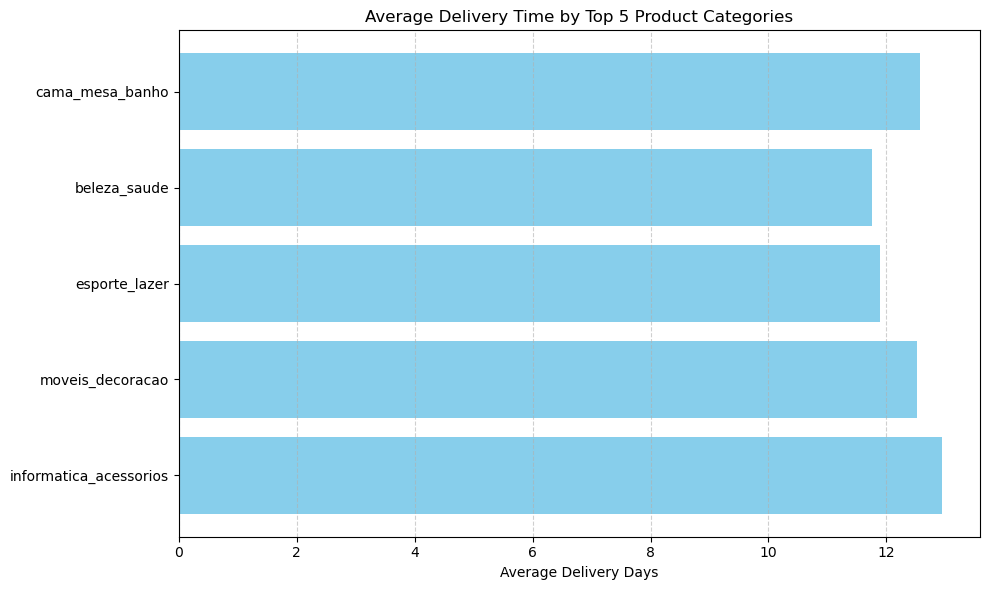

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
# Step 2: Query the data

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics' 

# Create connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# SQL Query (the final one with category names hard-coded)
query = """
SELECT 
    p.product_category_name,
    COUNT(*) AS order_count,
    ROUND(AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)), 2) AS avg_delivery_days
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_purchase_timestamp IS NOT NULL
  AND DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) BETWEEN 0 AND 60
GROUP BY p.product_category_name
ORDER BY order_count DESC
LIMIT 5;
"""

# data into df
df = pd.read_sql(query, engine)

# Plot visual
plt.figure(figsize=(10, 6))
plt.barh(df['product_category_name'], df['avg_delivery_days'], color='skyblue')
plt.xlabel('Average Delivery Days')
plt.title('Average Delivery Time by Top 5 Product Categories')
plt.gca().invert_yaxis()  # so highest value is at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 📦 Average Delivery Time by Top 5 Product Categories

This horizontal bar chart visualizes the **average delivery days** for the **top 5 most ordered product categories**. Each bar represents the mean delivery time (in days) based on the difference between the order purchase and delivery timestamps.

**Key Observations:**

- **"cama_mesa_banho"** has the highest average delivery time among the top 5, indicating possible logistical challenges in this category.
- **"beleza_saude"** and **"esporte_lazer"** have slightly shorter delivery periods, potentially due to more optimized fulfillment processes or localized inventory.
- The differences, although small (within a ~2-day range), can compound over thousands of orders and significantly affect **customer satisfaction** and **review scores**.

These insights can guide logistics teams on where to **improve delivery efficiency** and help prioritize **category-specific delivery optimizations**.


In [11]:
print(df.columns)


Index(['product_category_name', 'order_count', 'avg_delivery_days'], dtype='object')


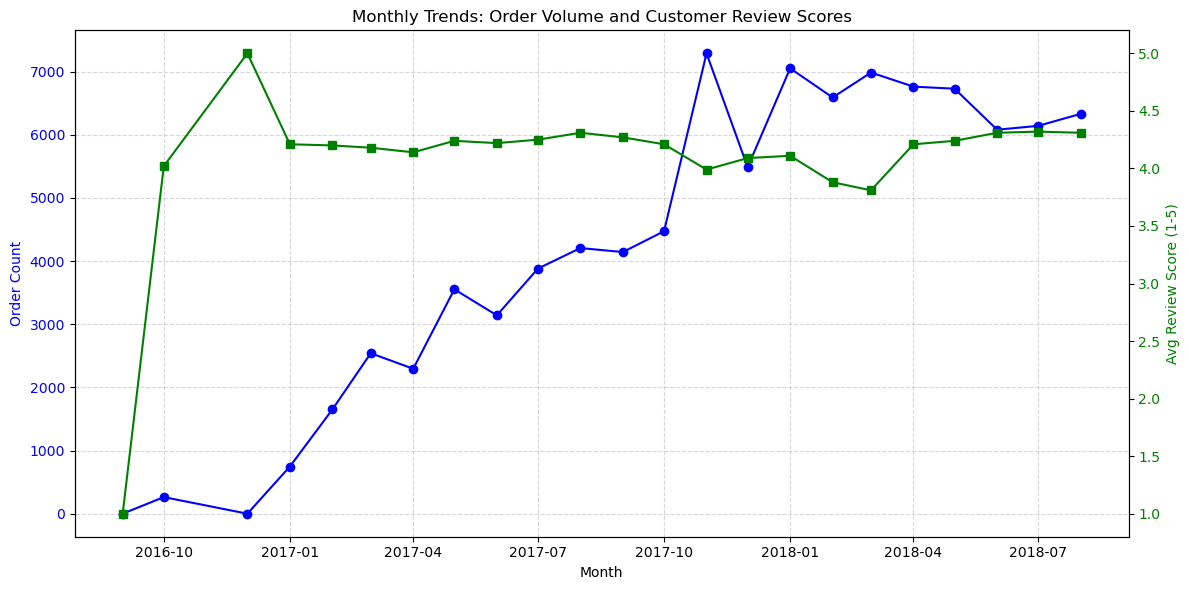

In [17]:

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics' #DB Name

# Create connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# SQL Query (the final one with category names hard-coded)
query = """
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp, '%%Y-%%m') AS order_month,
    COUNT(*) AS order_count,
    ROUND(AVG(r.review_score), 2) AS avg_review_score
FROM orders o
JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_purchase_timestamp IS NOT NULL
  AND r.review_score IS NOT NULL
GROUP BY order_month
ORDER BY order_month;
"""


# Load data into Df
df = pd.read_sql(query, engine)
# Convert order_month to datetime for proper plotting
df['order_month'] = pd.to_datetime(df['order_month'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot order count (primary y-axis)
ax1.plot(df['order_month'], df['order_count'], color='blue', marker='o', label='Order Count')
ax1.set_xlabel('Month')
ax1.set_ylabel('Order Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot review score (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(df['order_month'], df['avg_review_score'], color='green', marker='s', label='Avg Review Score')
ax2.set_ylabel('Avg Review Score (1-5)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Monthly Trends: Order Volume and Customer Review Scores')
fig.tight_layout()
plt.show()

### 📊 Monthly Trends: Order Volume and Customer Review Scores

This dual-axis line chart displays the **monthly trend** of:
- 📦 **Order Count** (Blue Line - left Y-axis)
- ⭐ **Average Review Score** (Green Line - right Y-axis)  
between late 2016 and mid-2018.

**Key Insights:**

- **Steady Growth**: There's a consistent increase in monthly order volume from late 2016 to early 2018, indicating business expansion and customer acquisition.
- **Volatility in Early Months**: The initial spike and dip in review scores during the early months may suggest challenges in order fulfillment or data sparsity.
- **Review Score Stability**: From early 2017 onward, review scores stabilize around **4.0–4.5**, showing that customer satisfaction remained relatively high even with growing order volume.
- **Notable Dips**: Occasional dips in average review score (e.g., late 2017 and early 2018) may correspond to operational strain due to high order volume, warranting further investigation.

This chart helps track **seasonality**, **operational capacity**, and **customer experience trends** over time, which are crucial for **forecasting demand** and maintaining **service quality**.


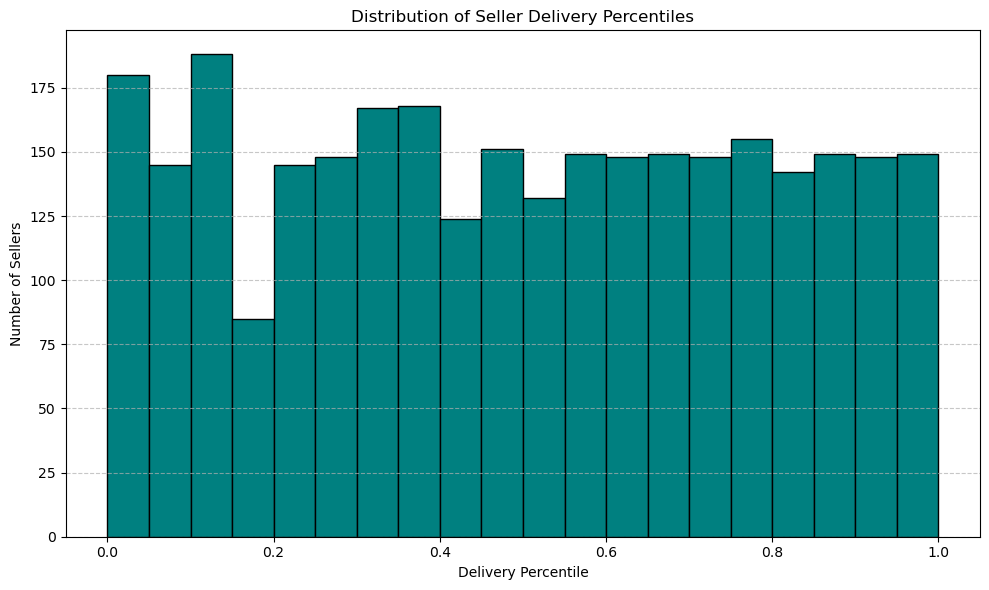

In [10]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'Customer_Analytics' #DB Name

# Create connection
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

query = """
SELECT 
    oi.seller_id,
    AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)) AS avg_delivery_days,
    PERCENT_RANK() OVER (
        ORDER BY AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp))
    ) AS delivery_percentile
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_purchase_timestamp IS NOT NULL
GROUP BY oi.seller_id
ORDER BY avg_delivery_days ASC;
"""

df = pd.read_sql(query, engine)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['delivery_percentile'], bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Seller Delivery Percentiles')
plt.xlabel('Delivery Percentile')
plt.ylabel('Number of Sellers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 📦 Distribution of Seller Delivery Percentiles

This histogram illustrates the distribution of sellers based on their **delivery speed percentiles**, calculated using the `PERCENT_RANK()` SQL function.

**Key Concepts:**
- A **lower percentile** means faster delivery performance.
- A **higher percentile** indicates slower delivery relative to other sellers.

**Insights:**
- The distribution is **fairly uniform**, meaning sellers are spread relatively evenly across the delivery performance spectrum.
- However, there are **slight clusters** near the lower and upper percentiles, suggesting:
  - A notable number of sellers are either **very efficient** (0.0–0.1 range).
  - Or **consistently slower** (0.9–1.0 range).
- The spike around **0.2–0.4** and dip at **0.15–0.2** might indicate inconsistency in delivery performance within that middle-performing segment.

**Use Case:**
This analysis helps identify:
- 📈 **Top-performing sellers** for promotions or prioritization.
- ⚠️ **Underperforming sellers** who may require support, guidance, or re-evaluation.

This type of peuseful ranking is powerful for **benchmarking seller performance** across large marketplaces.


In [12]:
top_sellers = df[df['delivery_percentile'] <= 0.1]
print(top_sellers.head())


                          seller_id  avg_delivery_days  delivery_percentile
0  5e063e85d44b0f5c3e6ec3131103a57e                1.0              0.00000
1  6561d6bf844e464b4019442692b40e02                1.0              0.00000
2  139157dd4daa45c25b0807ffff348363                1.0              0.00000
3  751e274377499a8503fd6243ad9c56f6                2.0              0.00101
4  26562f211dd1364af2a8596dc945e8ae                2.0              0.00101


In [80]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# MySQL connection
user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'customer_analytics'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# Run the query
query = """
SELECT
    o.order_id,
    o.customer_id,
    o.order_purchase_timestamp,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) AS delivery_days,
    DATEDIFF(o.order_estimated_delivery_date, o.order_purchase_timestamp) AS estimated_days,
    DAYOFWEEK(o.order_purchase_timestamp) AS purchase_dayofweek,
    HOUR(o.order_purchase_timestamp) AS purchase_hour,
    p.payment_type,
    i.seller_id,
    i.price,
    i.freight_value,
    pr.product_category_name,
    c.customer_state,
    CASE
        WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date THEN 1
        ELSE 0
    END AS is_late
FROM orders o
JOIN order_items i ON o.order_id = i.order_id
JOIN order_payments p ON o.order_id = p.order_id
JOIN products pr ON i.product_id = pr.product_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_estimated_delivery_date IS NOT NULL;
"""

# Load into DataFrame
df = pd.read_sql(query, engine)


In [81]:
print(df.shape)
print(df.head())
print(df['is_late'].value_counts())


(115027, 16)
                           order_id                       customer_id  \
0  595f598849d89203c28d05d0fbf3f92e  cefab390926b6fc3de3ca94c82ebb1ba   
1  710770cfb61b2c43a091ab2c7b89a921  f3df91219ffe2fb3e399377acfd0e527   
2  1767c122a3ee029a66f97b74a2538d2e  d01dc54fcf3bf7bf2fee5926f43e0516   
3  6a1dff28da32815c94da401e19d2a7f8  29251d6a551cedc7040b152221744460   
4  7ebe19943d85e81a7b0eb108681276b7  fa3a8736d5ae8f7df9b0a4154d0b14dc   

  order_purchase_timestamp order_delivered_customer_date  \
0      2017-09-25 16:38:46           2017-10-02 20:55:55   
1      2018-01-06 14:25:01           2018-01-16 17:51:36   
2      2018-01-11 14:48:38           2018-01-22 21:42:24   
3      2017-03-21 11:33:31           2017-03-31 15:34:11   
4      2018-07-22 10:28:14           2018-07-26 16:42:42   

  order_estimated_delivery_date  delivery_days  estimated_days  \
0           2017-10-19 00:00:00              7              24   
1           2018-02-02 00:00:00             10         

**Here's what that means:**

0 = On time deliveries: 106,004 orders

1 = Late deliveries (our target): 9,023 orders

That’s roughly 7.8% of deliveries were late, which gives us a class imbalance — something we’ll handle in modeling.**

In [83]:
print(df.isnull())

        order_id  customer_id  order_purchase_timestamp  \
0          False        False                     False   
1          False        False                     False   
2          False        False                     False   
3          False        False                     False   
4          False        False                     False   
...          ...          ...                       ...   
115022     False        False                     False   
115023     False        False                     False   
115024     False        False                     False   
115025     False        False                     False   
115026     False        False                     False   

        order_delivered_customer_date  order_estimated_delivery_date  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3  

In [84]:
null_data = df[df.isnull().any(axis=1)]

In [85]:
print(null_data)

                                order_id                       customer_id  \
87      58ac1947c1a9067b9f416cba6d844a3f  ee8e1d37f563ecc11cc4dcb4dfd794c2   
128     42c99d4e378b852657e71d810ef1858c  13ab4c98a7678b10d69118bb719e57c9   
186     769cad60df1d40dccfd5ec163be24654  ce0518f0279ef8b73d94633720e70b9f   
282     378aab9f026bcce6c5d6b5b6453be88a  37c19e14f0f664e83d2068be6b1f44dc   
367     1b99333d39cf95f48be3864b2e1e88b3  01b2ab1c903b4ecd0442a3ce48d89caa   
...                                  ...                               ...   
114776  bab0f0b79b3da1f56810300638d94112  ba7104a3bd3187a49b7e2b5f8eb2b1b9   
114826  48d0129c92992c4ee4c6b7b034c63336  85d622312fac76fa9a79eece3fe2eb9d   
114849  8c4bbf2fb218d1ac2fc4fc082c238d64  8b2b23a05a38be46121f4f5d2f0e4f99   
114881  54e18621b0dcda1233f2d5bda4effa58  34276b3f27fe1d0bf5e96b9b42c1cc1f   
114981  d3a0f468db524dedfb22ab7ef248b16f  839490da81c03456fbeec08f5451522d   

       order_purchase_timestamp order_delivered_customer_date  

In [86]:
# Count null values in each column
null_counts = df.isnull().sum()
print(null_counts)

order_id                            0
customer_id                         0
order_purchase_timestamp            0
order_delivered_customer_date       0
order_estimated_delivery_date       0
delivery_days                       0
estimated_days                      0
purchase_dayofweek                  0
purchase_hour                       0
payment_type                        0
seller_id                           0
price                               0
freight_value                       0
product_category_name            1628
customer_state                      0
is_late                             0
dtype: int64


In [87]:
# So we would replcae the missing values in the product_category_name with the variable "Unknown"

df["product_category_name"].fillna('Unknown', inplace= True )

In [88]:
null_counts = df.isnull().sum()
print(null_counts)

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_delivered_customer_date    0
order_estimated_delivery_date    0
delivery_days                    0
estimated_days                   0
purchase_dayofweek               0
purchase_hour                    0
payment_type                     0
seller_id                        0
price                            0
freight_value                    0
product_category_name            0
customer_state                   0
is_late                          0
dtype: int64



=== Classification Report (Threshold = 0.25) ===
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     21201
           1       0.22      0.49      0.30      1805

    accuracy                           0.83     23006
   macro avg       0.59      0.67      0.60     23006
weighted avg       0.89      0.83      0.85     23006



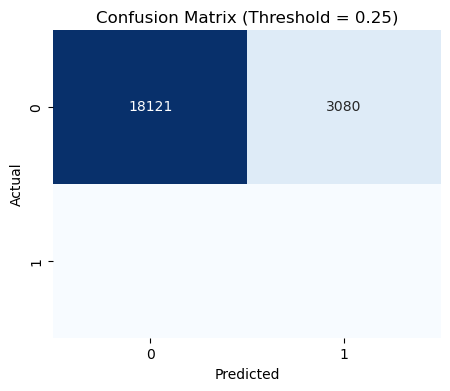


=== Classification Report (Threshold = 0.3) ===
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     21201
           1       0.26      0.40      0.31      1805

    accuracy                           0.86     23006
   macro avg       0.60      0.65      0.62     23006
weighted avg       0.89      0.86      0.88     23006



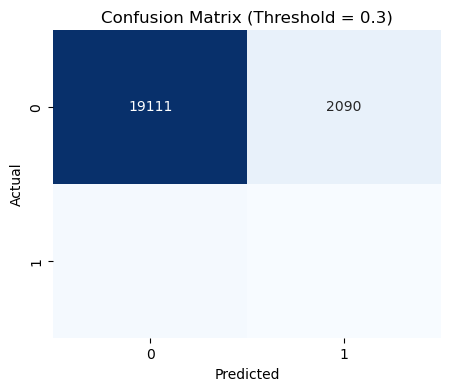


=== Classification Report (Threshold = 0.35) ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     21201
           1       0.30      0.34      0.32      1805

    accuracy                           0.89     23006
   macro avg       0.62      0.64      0.63     23006
weighted avg       0.89      0.89      0.89     23006



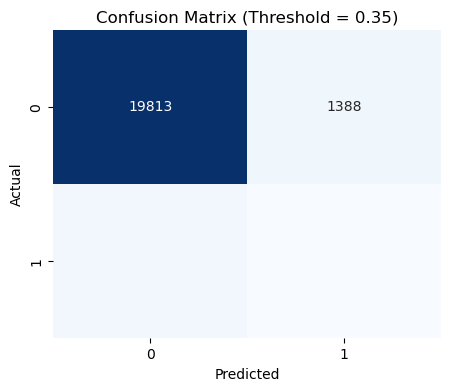

In [89]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Custom Transformer
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['is_weekend_purchase'] = X['purchase_dayofweek'].isin([5, 6]).astype(int)
        X['freight_ratio'] = (X['freight_value'] / (X['price'] + 1e-5)).replace([np.inf, -np.inf], 0).fillna(0)
        drop_cols = ['order_id', 'customer_id', 'order_purchase_timestamp', 
                     'order_delivered_customer_date', 'order_estimated_delivery_date', 'delivery_days']
        X = X.drop(columns=[col for col in drop_cols if col in X.columns])
        return X

# 2. Features
categorical_features = ['payment_type', 'product_category_name', 'customer_state']
numerical_features = [
    'estimated_days', 
    'purchase_dayofweek', 
    'purchase_hour', 
    'price', 
    'freight_value', 
    'is_weekend_purchase', 
    'freight_ratio'
]

# 3. Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# 4. Full pipeline
full_pipeline = ImbPipeline(steps=[
    ('feature_eng', FeatureEngineer()),
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 5. Load data
X = df.drop(columns=['is_late'])
y = df['is_late']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Fit pipeline
full_pipeline.fit(X_train, y_train)

# 7. Predict and evaluate at multiple thresholds
y_probs = full_pipeline.predict_proba(X_test)[:, 1]
thresholds = [0.25, 0.3, 0.35]

for thresh in thresholds:
    print(f"\n=== Classification Report (Threshold = {thresh}) ===")
    y_pred_thresh = (y_probs >= thresh).astype(int)
    print(classification_report(y_test, y_pred_thresh, digits=2))
    cm = confusion_matrix(y_test, y_pred_thresh)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix (Threshold = {thresh})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


##  Predictive Model: Delivery Risk Classification Using Random Forest

In this section, we built a predictive model to classify whether an order will be **delivered late or on time** using a **Random Forest Classifier** wrapped in a full pipeline with feature engineering and SMOTE oversampling.

---
### 🔧 Pipeline Components

- **Custom Transformer (`FeatureEngineer`)**:
  - Derived new features like:
    - `is_weekend_purchase`: Whether the purchase occurred on a weekend.
    - `freight_ratio`: Ratio of freight value to product price.
  - Dropped irrelevant or leakage-prone columns.

- **Preprocessing**:
  - **Numerical features**: Median imputation + Standard scaling.
  - **Categorical features**: Constant imputation + One-hot encoding.

- **Oversampling**: Applied **SMOTE** to handle class imbalance between late and on-time deliveries.

- **Model**: `RandomForestClassifier` with class weighting to further handle ialance.

---

### 📊 Evaluation Strategy

We tested model performance using **3 different probability thresholds**:

| Threshold | Focus        | Use Case Scenario                          |
|-----------|--------------|-------------------------------------------|
| 0.25      | 🔍 Recall     | Capture as many late deliveries as possible k-averse)   |
| 0.30      | ⚖️  Balanced  | Trade-off between precision anrecall        |
| 0.35      | ✅ Precision  | Minimize false positives (actionable alerts) |

---

### 📈 Results Summary

#### 🔹 Threshold = 0.25
- **Recall** for late deliveries: **0.49** (captures ~49% of late orders)
- **Precision**: 0.22 (many false positives)
- **Use case**: Good for broad risk identification (flagging potential issues early)

#### 🔹 Threshold = 0.30
- **Recall**: 0.40
- **Precision**: 0.26
- **Accuracy**: 86%
- **Use case**: Balanced performance suitable for general dashboards or alerts

#### 🔹 Threshold = 0.35
- **Recall**: 0.34
- **Precision**: 0.30
- **Accuracy**: 89%
- **Use case**: More conservative — better for operational irventions (e.g., call center follow-up)

---

### 🧠 Takeaway

- **Model performs very well on non-late (class 0) orders**, consistently with high precision and recall.
- Late deliveries (class 1) are more difficult to classify, which is typical due to class imbalance and noise.
- Adjusting the threshold allows stakeholders to **optimize for business goals** (maximize detection vs. minimize false alarms).


In [99]:
import joblib

# Save trained pipeline
joblib.dump(full_pipeline, 'delivery_risk_pipeline_main.joblib')

# Save chosen threshold
joblib.dump(0.3, 'delivery_risk_threshold.joblib')

print("✅ Pipeline and threshold saved successfully.")


✅ Pipeline and threshold saved successfully.


In [101]:
import joblib
import pandas as pd

# === 1. Load the saved pipeline and threshold ===
pipeline = joblib.load("delivery_risk_pipeline_main.joblib")
threshold = joblib.load("delivery_risk_threshold.joblib")  # Should be a float like 0.30

# === 2. Create a sample new order input ===
# Must match the structure of original training features (before transformation)
new_order_data = pd.DataFrame([{
    'estimated_days': 5,
    'purchase_dayofweek': 2,
    'purchase_hour': 14,
    'price': 100.0,
    'freight_value': 15.0,
    'payment_type': 'credit_card',
    'product_category_name': 'eletronicos',
    'customer_state': 'SP',
    'freight_ratio': 0.15,
    'is_weekend_purchase': 0
}])

# === 3. Predict probability and flag risk ===
probability = pipeline.predict_proba(new_order_data)[0][1]  # Probability of class 1 (late)
risk_flag = int(probability > threshold)

# === 4. Output result ===
print(f"Predicted probability of order being delayed: {probability:.2f}")
print(f"is it at risk of delay? {'Yes' if risk_flag else 'No'}")


Predicted probability of order being delayed: 0.66
is it at risk of delay? Yes


In [109]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# MySQL connection
user = 'root'
password = 'Oluwaseun100$'
host = 'localhost'
port = '3306'
database = 'customer_analytics'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# Run the query
query = """
SELECT
    o.order_id,
    o.customer_id,
    o.order_purchase_timestamp,
    o.order_estimated_delivery_date,
    DATEDIFF(o.order_estimated_delivery_date, o.order_purchase_timestamp) AS estimated_days,
    DAYOFWEEK(o.order_purchase_timestamp) AS purchase_dayofweek,
    HOUR(o.order_purchase_timestamp) AS purchase_hour,
    p.payment_type,
    i.seller_id,
    i.price,
    i.freight_value,
    pr.product_category_name,
    c.customer_state
FROM orders o
JOIN order_items i ON o.order_id = i.order_id
JOIN order_payments p ON o.order_id = p.order_id
JOIN products pr ON i.product_id = pr.product_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'processing'
  AND o.order_estimated_delivery_date IS NOT NULL
  AND o.order_purchase_timestamp IS NOT NULL;
"""

# Load into DataFrame
new_order_df = pd.read_sql(query, engine)

In [110]:
X_new = new_order_df.copy()  # keep original safe
y_probs = pipeline.predict_proba(X_new)[:, 1]
y_pred = (y_probs >= threshold).astype(int)

# 4. Add prediction result to your DataFrame
new_order_df['predicted_late'] = y_pred
new_order_df['late_probability'] = y_probs.round(3)

# 5. View results
print(new_order_df[['order_id', 'predicted_late', 'late_probability']].head())

                           order_id  predicted_late  late_probability
0  c79bdf061e22288609201ec60deb42fb               0              0.13
1  ede510a059fd07ccec20bff19a227fa3               0              0.10
2  ede510a059fd07ccec20bff19a227fa3               0              0.10
3  ede510a059fd07ccec20bff19a227fa3               0              0.10
4  6c98fa39891b33399785aeac3d7ee926               1              0.39


In [113]:
print(new_order_df.head())

                           order_id                       customer_id  \
0  c79bdf061e22288609201ec60deb42fb  fe4176df564772c058286208c0daa2a8   
1  ede510a059fd07ccec20bff19a227fa3  4b346b47b84bd54b2fdac6fb7963f1d5   
2  ede510a059fd07ccec20bff19a227fa3  4b346b47b84bd54b2fdac6fb7963f1d5   
3  ede510a059fd07ccec20bff19a227fa3  4b346b47b84bd54b2fdac6fb7963f1d5   
4  6c98fa39891b33399785aeac3d7ee926  0c2473e5a7533f687f8e6aa29efbdc7d   

  order_purchase_timestamp order_estimated_delivery_date  estimated_days  \
0      2017-05-01 18:58:54           2017-06-06 00:00:00              36   
1      2017-10-23 16:42:15           2017-11-08 00:00:00              16   
2      2017-10-23 16:42:15           2017-11-08 00:00:00              16   
3      2017-10-23 16:42:15           2017-11-08 00:00:00              16   
4      2017-02-28 12:49:50           2017-03-24 00:00:00              24   

   purchase_dayofweek  purchase_hour payment_type  \
0                   2             18  credit_card  

## 🚀 Deployment Simulation: Predicting Late Deliveries in Real-Time

To simulate production-like prediction, we implemented both **single input prediction** and **batch inference** from a live MySQL database.

---

### ✅ Saving the Model and Threshold

We used `joblib` to persist the trained pipeline and selected decision threshold (`0.30`) for consistent inference across environments.

```python
joblib.dump(full_pipeline, 'delivery_risk_pipeline_main.joblib')
joblib.dump(0.3, 'delivery_risk_threshold.joblib')
```

---

### 🧪 Example 1: Predicting a Single Order

We created a test record manually and passed it through the pipeline:

```python
new_order_data = pd.DataFrame([{
    'estimated_days': 5,
    'purchase_dayofweek': 2,
    'purchase_hour': 14,
    'price': 100.0,
    'freight_value': 15.0,
    'payment_type': 'credit_card',
    'product_category_name': 'eletronicos',
    'customer_state': 'SP',
    'freight_ratio': 0.15,
    'is_weekend_purchase': 0
}])
```

**Result:**

- **Predicted Probability:** `0.66`
- **Risk Flag:** `Yes` (order likely to be late)

---

### 🧪 Example 2: Batch Prediction from SQL Database

We queried live orders currently in **`processing`** status:

```sql
SELECT 
  o.order_id, o.customer_id, o.order_purchase_timestamp,
  o.order_estimated_delivery_date,
  DATEDIFF(o.order_estimated_delivery_date, o.order_purchase_timestamp) AS estimated_days,
  DAYOFWEEK(o.order_purchase_timestamp) AS purchase_dayofweek,
  HOUR(o.order_purchase_timestamp) AS purchase_hour,
  p.payment_type, i.seller_id, i.price, i.freight_value,
  pr.product_category_name, c.customer_state
FROM orders o
...
WHERE o.order_status = 'processing'
```

Predictions were made in batch using:

```python
y_probs = pipeline.predict_proba(X_new)[:, 1]
y_pred = (y_probs >= threshold).astype(int)
```

The resulting dataframe included:

| Order ID                              | Predicted Late | Late Probability |
|---------------------------------------|----------------|------------------|
| c79bdf061e22288609201ec60deb42fb      | 0              | 0.13             |
| ede510a059fd07ccec20bff19a227fa3      | 0              | 0.10             |
| 6c98fa39891b33399785aeac3d7ee926      | 1              | 0.39             |

---

### 📌 Insights

- This setup allows **real-time scoring** from a production database.
- Predictions can be integrated into **dashboards**, **alerts**, or **workflow automations**.
- Threshold can be dynamically tuned to suit business needs (e.g., SLA risk alerts).